# Imports & Functions

In [11]:
from datetime import datetime, time
import pandas as pd
# from sodapy import Socrata
import numpy as np 
import ast
import json
import pandasql
import matplotlib.pyplot as plt

In [12]:
morningStart = time(6, 0, 0)
morningEnd = time(12,0,0)
afternoonStart = time(12,0,1)
afternoonEnd = time(18,30,0)
nightStart = time(18,31,0)
nightEnd = time(23,59,59)
midnightStart = time(0,0,0)
midnightEnd = time(5,59,0)
springStart = 3
springEnd = 5
summerStart = 6
summerEnd = 8
fallStart = 9
fallEnd = 11
winterStart = 12
winterEnd = 2 

# Time of Day Function
def timeOfDayApplier(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
    
    if morningStart <= DatetimeVersion.time() <= morningEnd:
        return "Morning"
    elif afternoonStart <= DatetimeVersion.time() <= afternoonEnd:
        return "Afternoon/Evening"
    elif nightStart <= DatetimeVersion.time() <= nightEnd:
        return "Night"
    elif midnightStart <= DatetimeVersion.time() <= midnightEnd:
        return "Midnight"


# Time of Day Function
def seasonOfYear(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.month in [12,1,2]:
        return "Winter"   
    elif springStart <= DatetimeVersion.month <= springEnd:
        return "Spring"
    elif summerStart <= DatetimeVersion.month <= summerEnd:
        return "Summer"
    elif fallStart <= DatetimeVersion.month <= fallEnd:
        return "Fall"

# Time of Day Function
def dayOfWeek(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.weekday() in [0,1,2,3,4]:
        return "Weekday"   
    else:
        return "Weekend"

# Data Preprocessing

In [13]:
# Connecting police districts to community area names off of community area coddes
CommunityToPoliceDistrict = []
with open('PoliceDistrictToCommunityNamesOutput.txt') as fp:
    for line in fp:
        communityNum, communityName, policeDist  = line.strip().split(":")
        communityName = communityName.strip()
        CommunityToPoliceDistrict.append({"Community_Area": float(communityNum), "Community_Name": communityName,
                                         "Police_District": policeDist})

CommunityPoliceDistrictDF = pd.DataFrame(CommunityToPoliceDistrict)

In [14]:
# Crime data from from the crimes csv with community area names for where the crime occured
CrimeData = pd.read_csv("Crimes2001_2020.csv",
                       dtype={'ID': int, 'Case Number' : str, 'Date' : str, 'Block' : str, 
                             'IUCR' : str, 'Primary Type' : str, 'Description' : str, 
                             'Location Description' : str, 'Arrest' : str, 'Domestic' : str, 'Beat' : str, 
                             'District' : float, 'Ward' : float, 'Community Area' : float, 'FBI Code' : str, 
                              'X Coordinate' : str, 'Y Coordinate' : str, 'Year' : int,'Updated On' : str,
                             'Latitude' : str, 'Longitude' : str, 'Location' : str}, )

CrimeData.rename(columns = {'Community Area':'Community_Area'}, inplace = True)
CrimeData = CrimeData.drop(['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location'], axis = 1)
SampledCrimeData = CrimeData
SampledCrimeData = SampledCrimeData.join(CommunityPoliceDistrictDF.set_index('Community_Area'), on='Community_Area')

In [15]:
# Used to Extract the data from the Socio Economic CSV File 
# To train our program what specific communities are better or worse off than average
# We can use .describe() to find the benchmark levels of poverty per community. Compare community to the average and give weightage 
columns = [
'Community_Area',
'community_area_name', 
'%_housing_crowded', 
'%_households_below_poverty', 
'%_age16_unemployed',
'%_age25_nohighschool',
'%_not_working_age',
'per_capita_income',
'hardship_index']
SocioeconomicData = pd.read_csv("SocioeconomicData.csv")
SocioeconomicData.columns = columns
SampledSocioeconomicCrimeData = SampledCrimeData.join(SocioeconomicData.set_index('Community_Area'), on='Community_Area')

In [16]:
# Adding census data to the sampled socioeconomic crime data df
CensusData = pd.read_csv("census_data.csv", sep ='\t')
#CensusData = CensusData[CensusData.columns[range(67)]]
CensusData = CensusData.rename(columns={'Average Household Size' : "Average_Household_Size",
                                       'Vacant Housing Units' : 'Vacant_Households'})

SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.merge(CensusData, on='Community_Area', how='left')
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.drop(
    ['Arrest', 'Domestic', 'FBI Code', 'IUCR', 'Beat', 'Ward',
    'Case Number', 'Block', 'Primary Type', 'Description','Location Description', 'District', 'Community_Area', 'Year',
       'Updated On', 'community_area_name', 'Police_District','Not Hispanic or Latino, American Indian and Alaska Native alone','Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone', 
     'Not Hispanic or Latino, Some Other Race alone','Not Hispanic or Latino, Two or More Races'], axis = 1)

SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.dropna()
SampledSocioeconomicCrimeData.rename(columns={'Not Hispanic or Latino, White alone' : 'Num_White',
       'Not Hispanic or Latino, Black or African American alone' : "Num_African_American",
       'Not Hispanic or Latino, Asian alone' : "Num_Asian",'Hispanic or Latino' : "Num_Hispanic"}, inplace = True)


In [17]:
# Add time of day to the crime data and socioeconomic data
SampledSocioeconomicCrimeData['TimeOfDay'] = SampledSocioeconomicCrimeData['Date'].map(timeOfDayApplier)
SampledSocioeconomicCrimeData['Season'] = SampledSocioeconomicCrimeData['Date'].map(seasonOfYear)
SampledSocioeconomicCrimeData['Weekday/Weekend'] = SampledSocioeconomicCrimeData['Date'].map(dayOfWeek)

SampledCrimeData['TimeOfDay'] = SampledCrimeData['Date'].map(timeOfDayApplier)
SampledCrimeData['Season'] = SampledCrimeData['Date'].map(seasonOfYear)
SampledCrimeData['Weekday/Weekend'] = SampledCrimeData['Date'].map(dayOfWeek)

In [18]:
# print("Columns: ", SampledCrimeData.columns)
# print(SampledCrimeData.head())
# print("Shape: ", SampledCrimeData.shape)

In [19]:
# Prepare data for pandasql statement
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.drop(['Community_Name_y'], axis = 1)
SampledSocioeconomicCrimeData.rename(columns = {'Community_Name_x':'Community_Name', '%_housing_crowded':'percent_housing_crowded',
                                   '%_households_below_poverty': 'percent_households_below_poverty',
                                   '%_age16_unemployed' : 'percent_age16_unemployed',
                                   '%_age25_nohighschool' : 'percent_age25_nohighschool'}, inplace = True)

In [37]:
query = """
WITH cr AS
(
    SELECT DISTINCT
    Community_Name
    ,percent_age16_unemployed
    ,percent_households_below_poverty
    ,percent_age25_nohighschool
    ,per_capita_income
    ,hardship_index
    ,Average_Household_Size
    ,Vacant_Households
    ,Num_Asian
    ,Num_African_American
    ,Num_White
    ,TimeOfDay
    ,Season
    , COUNT(*) AS crimes
    
    FROM SampledSocioeconomicCrimeData
    GROUP BY Community_Name, TimeOfDay, Season
)
SELECT 
    cr.Community_Name
    ,cr.percent_age16_unemployed
    ,cr.percent_households_below_poverty
    ,cr.percent_age25_nohighschool
    ,cr.per_capita_income
    ,cr.hardship_index
    ,cr.Average_Household_Size
    ,cr.Vacant_Households
    ,cr.Num_Asian
    ,cr.Num_African_American
    ,cr.Num_White
    ,cr.TimeOfDay
    ,cr.Season
    ,cr.crimes Num_Crimes
FROM cr
ORDER BY Num_Crimes DESC, cr.Community_Name;
"""

query2 = """
WITH cr AS
(
    SELECT DISTINCT
    Community_Name
    ,percent_age16_unemployed
    ,percent_households_below_poverty
    ,percent_age25_nohighschool
    ,per_capita_income
    ,hardship_index
    ,Average_Household_Size
    ,Vacant_Households
    ,Num_Asian
    ,Num_African_American
    ,Num_White
    , COUNT(*) AS crimes
    
    FROM SampledSocioeconomicCrimeData
    GROUP BY Community_Name
)
SELECT 
    cr.Community_Name
    ,cr.percent_age16_unemployed
    ,cr.percent_households_below_poverty
    ,cr.percent_age25_nohighschool
    ,cr.per_capita_income
    ,cr.hardship_index
    ,cr.Average_Household_Size
    ,cr.Vacant_Households
    ,cr.Num_Asian
    ,cr.Num_African_American
    ,cr.Num_White
    ,cr.crimes Num_Crimes
    
FROM cr
ORDER BY Num_Crimes DESC, cr.Community_Name;
"""


AggregatedDataframe = pandasql.sqldf(query, globals())
DataframeToVisualize = pandasql.sqldf(query2, globals())

print("Sample aggregated data: \n")
print(AggregatedDataframe[AggregatedDataframe['Community_Name'] == "AUSTIN"].head())
print("# CRIMES TOTAL: ",sum(AggregatedDataframe.Num_Crimes))

Sample aggregated data: 

  Community_Name  percent_age16_unemployed  percent_households_below_poverty  \
0         AUSTIN                      22.6                              28.6   
1         AUSTIN                      22.6                              28.6   
2         AUSTIN                      22.6                              28.6   
3         AUSTIN                      22.6                              28.6   
5         AUSTIN                      22.6                              28.6   

   percent_age25_nohighschool  per_capita_income  hardship_index  \
0                        24.4            15957.0            73.0   
1                        24.4            15957.0            73.0   
2                        24.4            15957.0            73.0   
3                        24.4            15957.0            73.0   
5                        24.4            15957.0            73.0   

   Average_Household_Size  Vacant_Households  Num_Asian  Num_African_American  \
0  

<IPython.core.display.Javascript object>


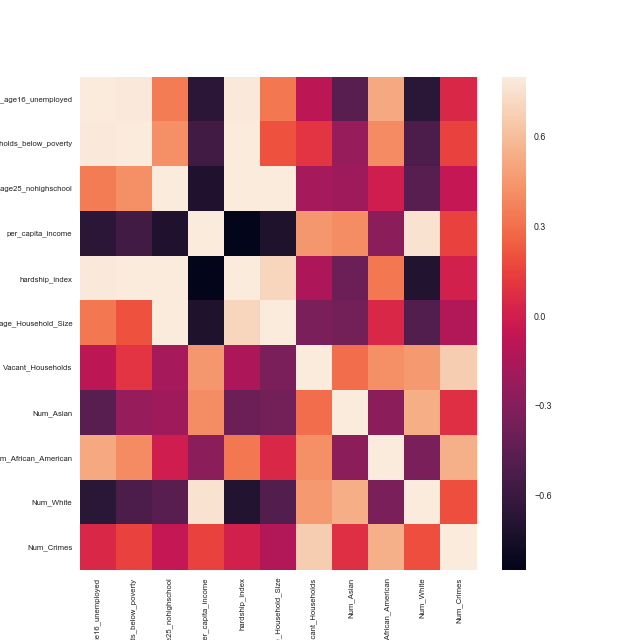

In [35]:
import seaborn as sns
%matplotlib notebook

corrmat = AggregatedDataframe.corr()
fig = plt.figure(figsize = (8, 8))
sns.set(font_scale=0.8)
sns.heatmap(corrmat, vmax = 0.8)
plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

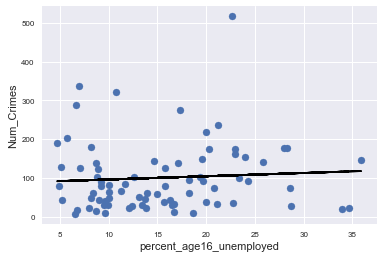

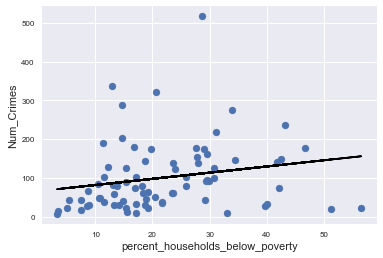

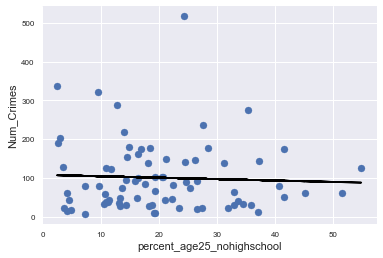

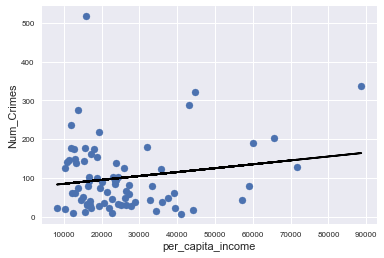

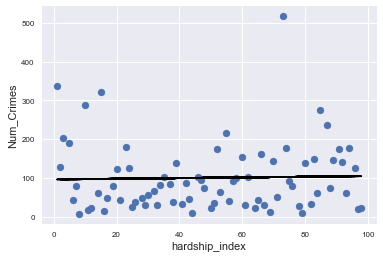

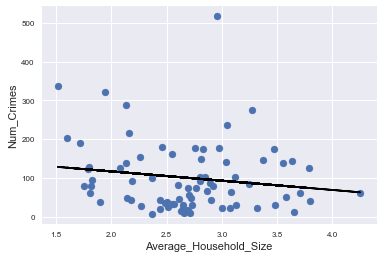

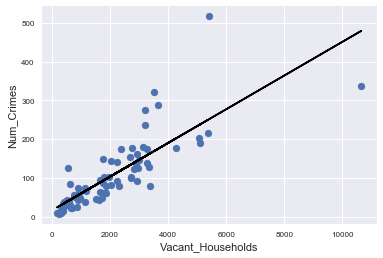

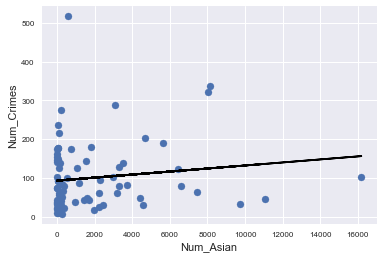

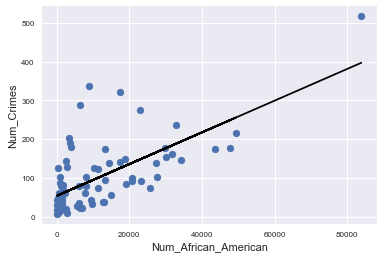

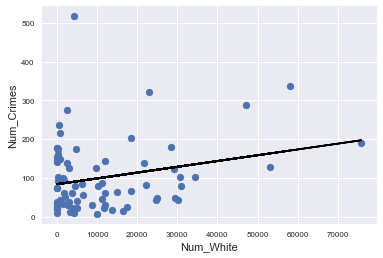

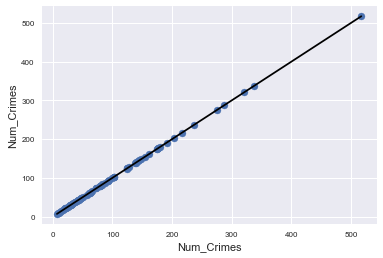

In [42]:
predictorColumns = DataframeToVisualize.columns
%matplotlib inline

for column in predictorColumns: 
    if column not in ['TimeOfDay', 'Season', 'Community_Name']:
        plt.scatter(x=DataframeToVisualize[column], y=DataframeToVisualize['Num_Crimes'])
        m, b = np.polyfit(DataframeToVisualize[column],DataframeToVisualize['Num_Crimes'], 1)
        plt.plot(DataframeToVisualize[column], m*DataframeToVisualize[column] + b,color='black')
        plt.xlabel(column, fontsize=11)
        plt.ylabel("Num_Crimes", fontsize=11)
        plt.show()

In [23]:
# For finding the most common type of crime
PrimaryCrimeTypes = SampledCrimeData['Primary Type'].unique()
PrimaryCrimeTypeCounts = pd.DataFrame()
for c in PrimaryCrimeTypes:
    df = SampledCrimeData[SampledCrimeData['Primary Type']==c]
    PrimaryCrimeTypeCounts[c] = df['Community_Name'].value_counts().sort_index()

# Contains counts of each primary type of crime for each community area
PrimaryCrimeTypeCounts.fillna(0) 
print("Crime Counts by Type of Crime by Community Area")
PrimaryCrimeTypeCounts

Crime Counts by Type of Crime by Community Area


,DECEPTIVE PRACTICE,CRIM SEXUAL ASSAULT,BURGLARY,THEFT,OFFENSE INVOLVING CHILDREN,CRIMINAL DAMAGE,OTHER OFFENSE,NARCOTICS,SEX OFFENSE,BATTERY,...,NON-CRIMINAL,PUBLIC PEACE VIOLATION,LIQUOR LAW VIOLATION,PROSTITUTION,INTIMIDATION,ARSON,INTERFERENCE WITH PUBLIC OFFICER,GAMBLING,STALKING,KIDNAPPING
ALBANY PARK,11,NaN,1.0,18,3.0,4.0,2.0,3.0,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARCHER HEIGHTS,4,NaN,NaN,10,4.0,1.0,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ASHBURN,21,1.0,7.0,18,5.0,7.0,3.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
AUBURN GRESHAM,39,5.0,5.0,41,9.0,9.0,7.0,21.0,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
AUSTIN,81,10.0,8.0,72,15.0,14.0,26.0,138.0,11.0,50.0,...,1.0,2.0,NaN,15.0,NaN,NaN,1.0,2.0,NaN,1.0
AVALON PARK,12,2.0,NaN,6,NaN,2.0,1.0,1.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVONDALE,15,4.0,2.0,21,1.0,2.0,4.0,3.0,NaN,6.0,...,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
BELMONT CRAGIN,13,4.0,7.0,42,9.0,7.0,7.0,6.0,8.0,5.0,...,1.0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
BEVERLY,8,NaN,1.0,6,NaN,1.0,1.0,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BRIDGEPORT,4,NaN,2.0,14,1.0,8.0,2.0,3.0,2.0,6.0,...,NaN,NaN,NaN,2.0,1.0,NaN,1.0,NaN,NaN,NaN


In [24]:
# Contains the most common type of crime for each community area
MostCommonPrimaryCrimeType = pd.DataFrame(PrimaryCrimeTypeCounts.idxmax(axis=1))
MostCommonPrimaryCrimeType.columns = ['Primary Type']
print(MostCommonPrimaryCrimeType)

                                      Primary Type
ALBANY PARK                                  THEFT
ARCHER HEIGHTS                               THEFT
ASHBURN                         DECEPTIVE PRACTICE
AUBURN GRESHAM                               THEFT
AUSTIN                                   NARCOTICS
AVALON PARK                     DECEPTIVE PRACTICE
AVONDALE                                     THEFT
BELMONT CRAGIN                               THEFT
BEVERLY                         DECEPTIVE PRACTICE
BRIDGEPORT                                   THEFT
BRIGHTON PARK                                THEFT
BURNSIDE                        DECEPTIVE PRACTICE
CALUMET HEIGHTS                 DECEPTIVE PRACTICE
CHATHAM                         DECEPTIVE PRACTICE
CHICAGO LAWN                    DECEPTIVE PRACTICE
CLEARING                                     THEFT
DOUGLAS                                      THEFT
DUNNING                                      THEFT
EAST GARFIELD PARK             

<IPython.core.display.Javascript object>


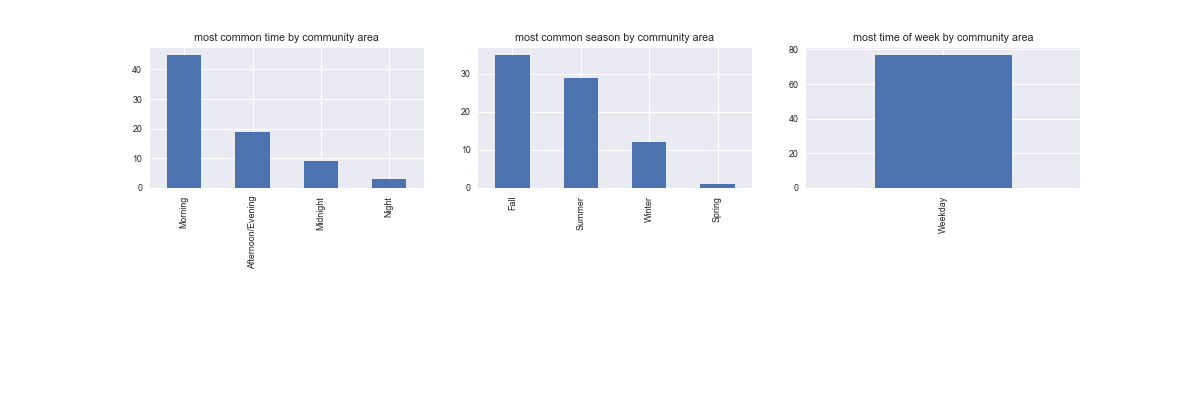

In [25]:
plt.subplot(1, 2, 1)

# Sums the most common type of crime for all community areas
TopPrimaryCrimeTypeCounts = MostCommonPrimaryCrimeType['Primary Type'].value_counts()
TopPrimaryCrimeTypeCounts.plot(kind='bar', title = 'Most Common Types of Crime for Each Community Area', figsize=(15,5))

plt.subplot(1, 2, 2)

# Sum of all of the crimes in Chicago
SampledCrimeData['Primary Type'].value_counts().plot(kind='bar', title = 'All Crimes in Chicago', figsize=(15,5))
plt.show()


PrimaryCrimeTypeCounts.plot.bar(stacked=True, figsize=(20,20), title = 'All Crimes in Chicago by Community Area')
plt.show()

In [26]:
# For finding the most common time/season/part of week for crimes by primary crime type

# By time
MostCommonCrimeTimeCounts = pd.DataFrame()
CrimeTimes = SampledCrimeData['TimeOfDay'].unique()
for c in CrimeTimes:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    MostCommonCrimeTimeCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeTimeCounts.fillna(0) 
MostCommonCrimeTime = pd.DataFrame(MostCommonCrimeTimeCounts.idxmax(axis=1))
MostCommonCrimeTime.columns = ['TimeOfDay']
print(MostCommonCrimeTime)
    
# By Season
MostCommonCrimeSeasonCounts = pd.DataFrame()
CrimeSesons = SampledCrimeData['Season'].unique()
for c in CrimeSesons:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    MostCommonCrimeSeasonCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeSeasonCounts.fillna(0)
MostCommonCrimeSeason = pd.DataFrame(MostCommonCrimeSeasonCounts.idxmax(axis=1))
MostCommonCrimeSeason.columns = ['Season']
print(MostCommonCrimeSeason)
    
# By time of week
MostCommonCrimeWeekCounts = pd.DataFrame()
CrimeWeek = SampledCrimeData['Weekday/Weekend'].unique()
for c in CrimeWeek:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    MostCommonCrimeWeekCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeWeekCounts.fillna(0)
MostCommonCrimeWeek = pd.DataFrame(MostCommonCrimeWeekCounts.idxmax(axis=1))
MostCommonCrimeWeek.columns = ['Weekday/Weekend']
print(MostCommonCrimeTime)

                                    TimeOfDay
ARSON                                Midnight
ASSAULT                     Afternoon/Evening
BATTERY                     Afternoon/Evening
BURGLARY                    Afternoon/Evening
CRIM SEXUAL ASSAULT                  Midnight
CRIMINAL DAMAGE             Afternoon/Evening
CRIMINAL TRESPASS                       Night
DECEPTIVE PRACTICE                    Morning
GAMBLING                    Afternoon/Evening
INTIMIDATION                          Morning
KIDNAPPING                              Night
LIQUOR LAW VIOLATION                    Night
MOTOR VEHICLE THEFT                     Night
NARCOTICS                   Afternoon/Evening
NON-CRIMINAL                          Morning
OBSCENITY                             Morning
OFFENSE INVOLVING CHILDREN           Midnight
OTHER OFFENSE                         Morning
PROSTITUTION                            Night
PUBLIC PEACE VIOLATION                  Night
ROBBERY                           

In [27]:
# For finding the most common time/season/part of week for crimes by community area

# By time
MostCommonCrimeTimeCountsCA = pd.DataFrame()
CrimeTimesCA = SampledCrimeData['TimeOfDay'].unique()
for c in CrimeTimesCA:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    MostCommonCrimeTimeCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeTimeCountsCA.fillna(0) 
MostCommonCrimeTimeCA = pd.DataFrame(MostCommonCrimeTimeCountsCA.idxmax(axis=1))
MostCommonCrimeTimeCA.columns = ['TimeOfDay']
print(MostCommonCrimeTimeCA)
    
# By Season
MostCommonCrimeSeasonCountsCA = pd.DataFrame()
CrimeSesonsCA = SampledCrimeData['Season'].unique()
for c in CrimeSesonsCA:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    MostCommonCrimeSeasonCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeSeasonCountsCA.fillna(0)
MostCommonCrimeSeasonCA = pd.DataFrame(MostCommonCrimeSeasonCountsCA.idxmax(axis=1))
MostCommonCrimeSeasonCA.columns = ['Season']
print(MostCommonCrimeSeasonCA)
    
# By time of week
MostCommonCrimeWeekCountsCA = pd.DataFrame()
CrimeWeekCA = SampledCrimeData['Weekday/Weekend'].unique()
for c in CrimeWeekCA:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    MostCommonCrimeWeekCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeWeekCountsCA.fillna(0)
MostCommonCrimeWeekCA = pd.DataFrame(MostCommonCrimeWeekCountsCA.idxmax(axis=1))
MostCommonCrimeWeekCA.columns = ['Weekday/Weekend']
print(MostCommonCrimeTimeCA)

                                TimeOfDay
ALBANY PARK                       Morning
ARCHER HEIGHTS                    Morning
ARMOUR SQUARE           Afternoon/Evening
ASHBURN                           Morning
AUBURN GRESHAM                    Morning
AUSTIN                            Morning
AVALON PARK                       Morning
AVONDALE                            Night
BELMONT CRAGIN          Afternoon/Evening
BEVERLY                           Morning
BRIDGEPORT                        Morning
BRIGHTON PARK                     Morning
BURNSIDE                          Morning
CALUMET HEIGHTS                   Morning
CHATHAM                           Morning
CHICAGO LAWN                      Morning
CLEARING                         Midnight
DOUGLAS                 Afternoon/Evening
DUNNING                           Morning
EAST GARFIELD PARK      Afternoon/Evening
EAST SIDE                         Morning
EDGEWATER                           Night
ENGLEWOOD                        M

In [28]:
plt.subplot(1, 3, 1)
MostCommonCrimeTimeCounts = MostCommonCrimeTime['TimeOfDay'].value_counts()
MostCommonCrimeTimeCounts.plot(kind='bar', title = 'most common time by primary crime type', figsize=(15,5))

plt.subplot(1, 3, 2)
MostCommonCrimeSeasonCounts = MostCommonCrimeSeason['Season'].value_counts()
MostCommonCrimeSeasonCounts.plot(kind='bar', title = 'most common season by primary crime type', figsize=(15,5))

plt.subplot(1, 3, 3)
MostCommonCrimeWeekCounts = MostCommonCrimeWeek['Weekday/Weekend'].value_counts()
MostCommonCrimeWeekCounts.plot(kind='bar', title = 'most time of week by primary crime type', figsize=(15,5))
plt.show()

plt.subplot(2, 3, 1)
MostCommonCrimeTimeCountsCA = MostCommonCrimeTimeCA['TimeOfDay'].value_counts()
MostCommonCrimeTimeCountsCA.plot(kind='bar', title = 'most common time by community area', figsize=(15,5))

plt.subplot(2, 3, 2)
MostCommonCrimeSeasonCountsCA = MostCommonCrimeSeasonCA['Season'].value_counts()
MostCommonCrimeSeasonCountsCA.plot(kind='bar', title = 'most common season by community area', figsize=(15,5))

plt.subplot(2, 3, 3)
MostCommonCrimeWeekCountsCA = MostCommonCrimeWeekCA['Weekday/Weekend'].value_counts()
MostCommonCrimeWeekCountsCA.plot(kind='bar', title = 'most time of week by community area', figsize=(15,5))
plt.show()

<IPython.core.display.Javascript object>


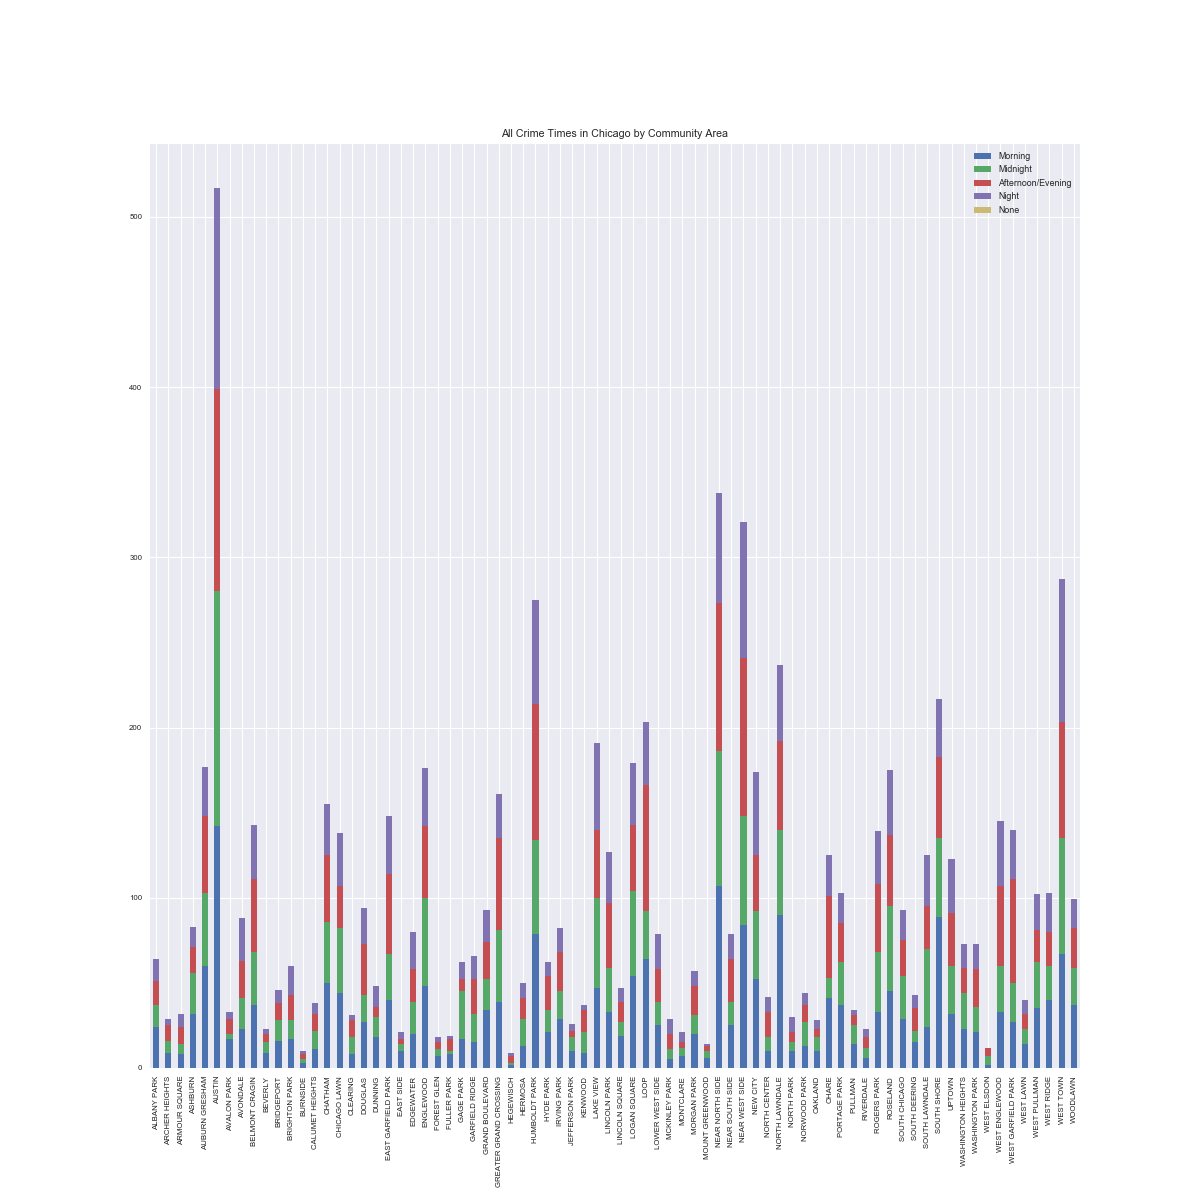

In [29]:
# For seeing all the times crimes are committed by community area
CrimeTimeCountsCA = pd.DataFrame()
for c in CrimeTimesCA:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    CrimeTimeCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeTimeCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

<IPython.core.display.Javascript object>


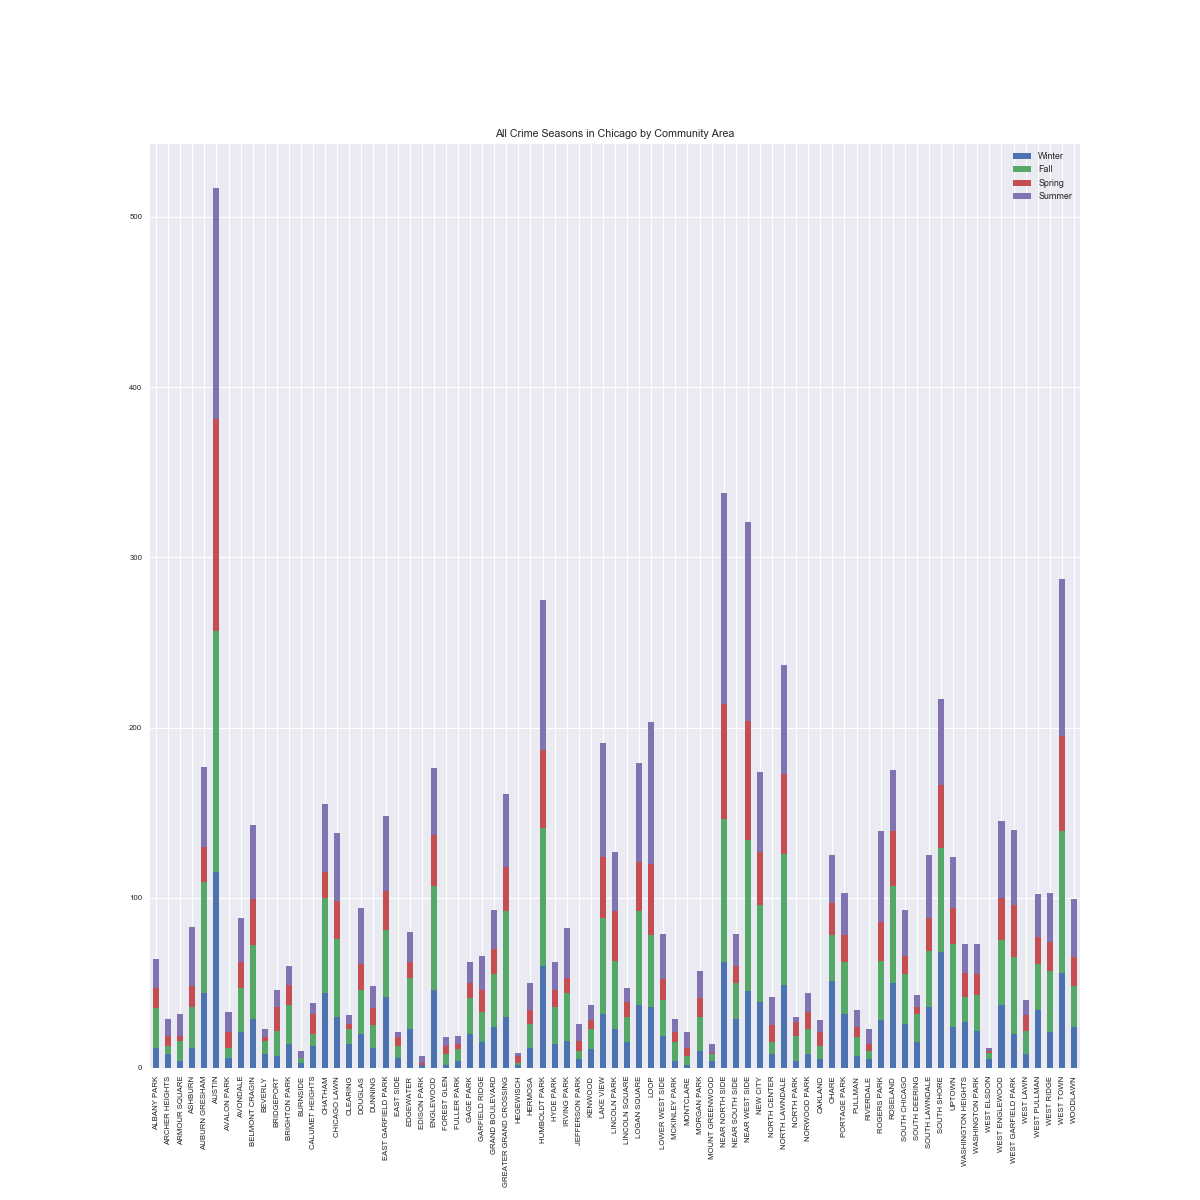

In [30]:
# For seeing all the seasons crimes are committed by community area
CrimeSeasonCountsCA = pd.DataFrame()
for c in CrimeSesonsCA:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    CrimeSeasonCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeSeasonCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Seasons in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

<IPython.core.display.Javascript object>


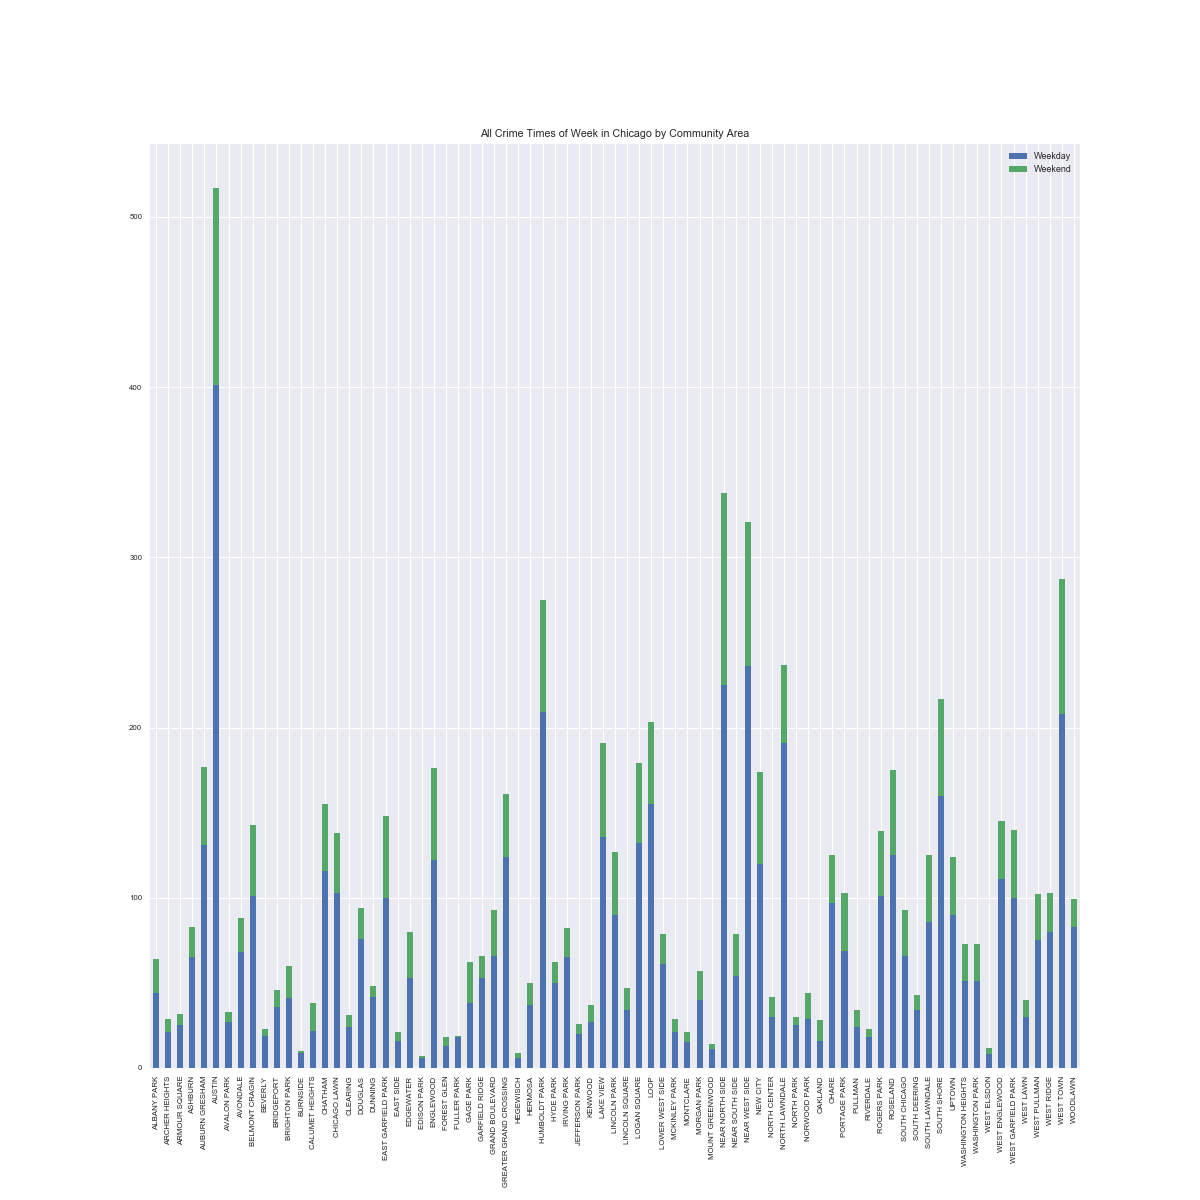

In [31]:
# For seeing all the time of week crimes are committed by community area
CrimeWeekCountsCA = pd.DataFrame()
for c in CrimeWeekCA:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    CrimeWeekCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeWeekCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times of Week in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

<IPython.core.display.Javascript object>


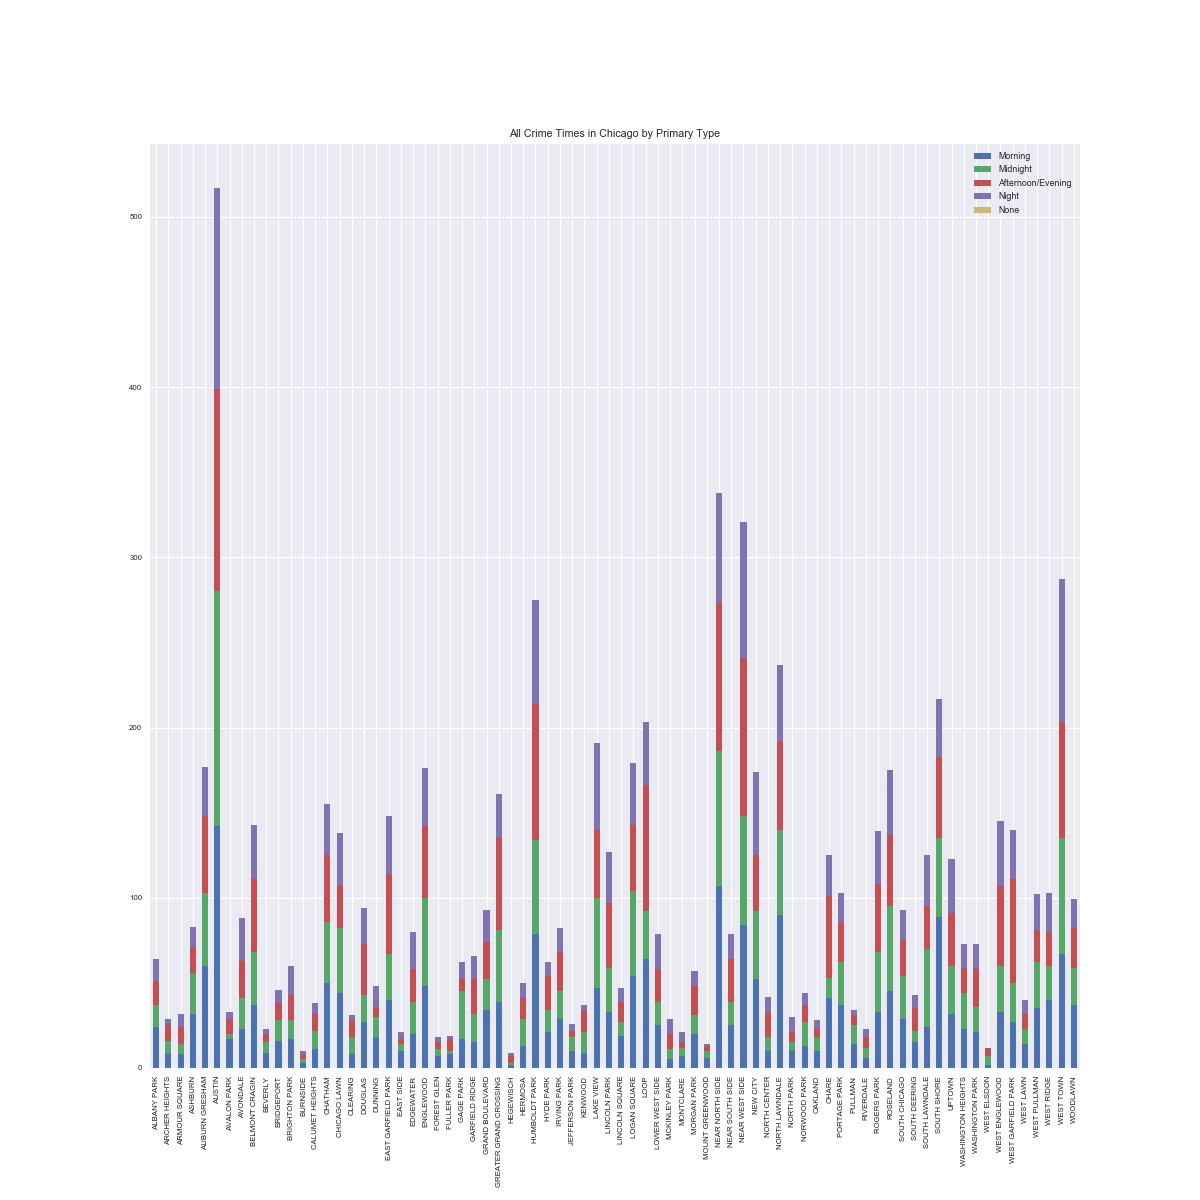

In [32]:
# For seeing all the times crimes are committed by primary type
CrimeTimeCounts = pd.DataFrame()
for c in CrimeTimes:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    CrimeTimeCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeTimeCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

<IPython.core.display.Javascript object>


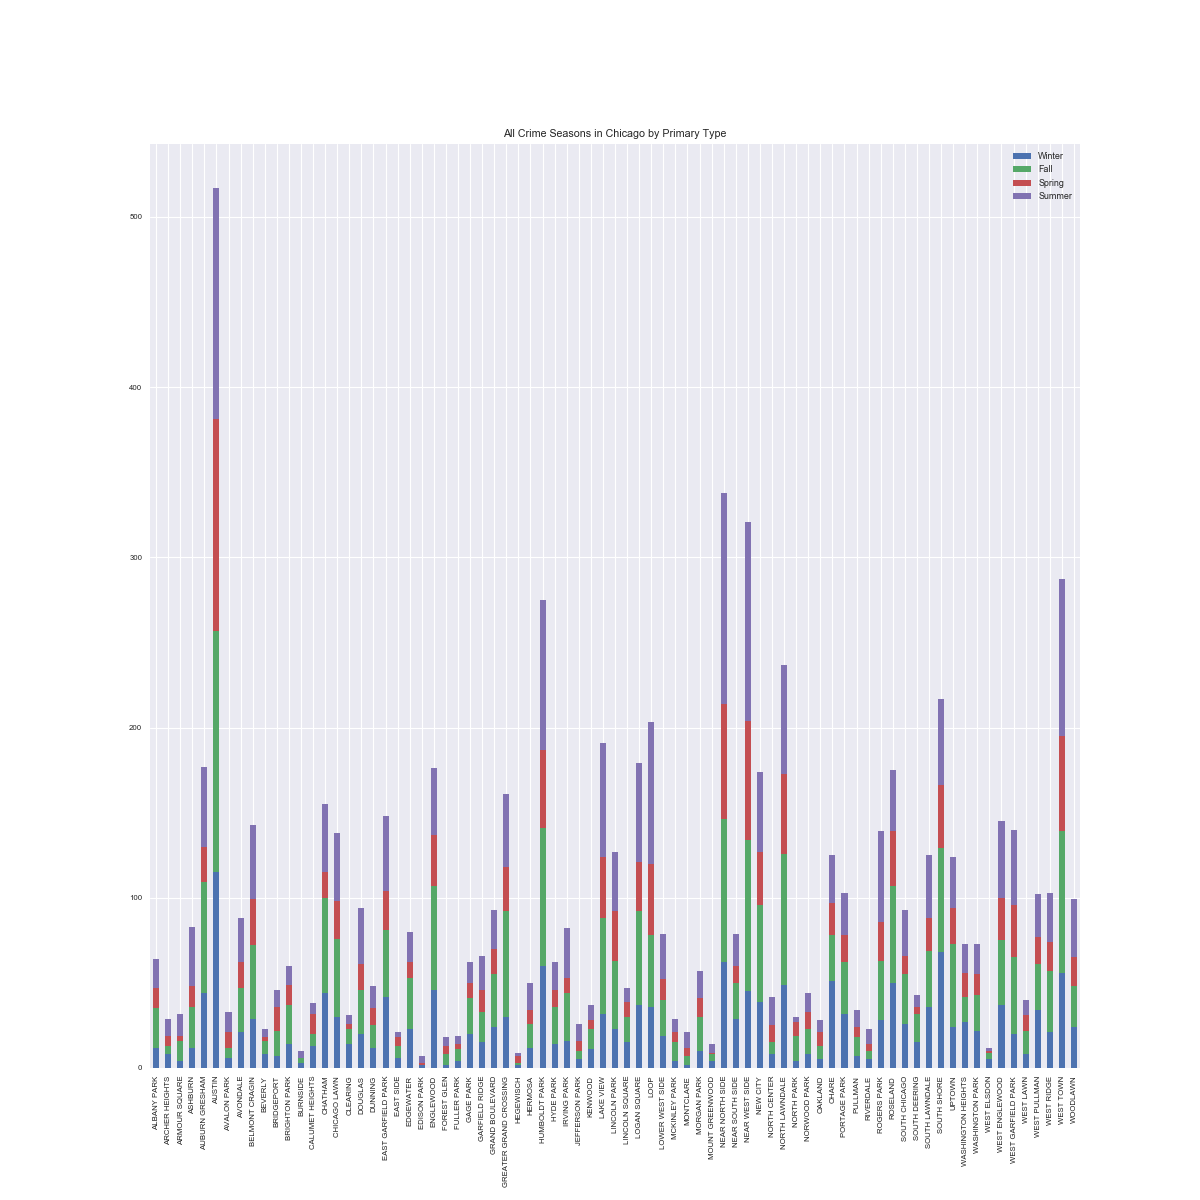

In [33]:
# For seeing all the seasons crimes are committed by primary type
CrimeSeasonCounts = pd.DataFrame()
for c in CrimeSesons:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    CrimeSeasonCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeSeasonCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Seasons in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

<IPython.core.display.Javascript object>


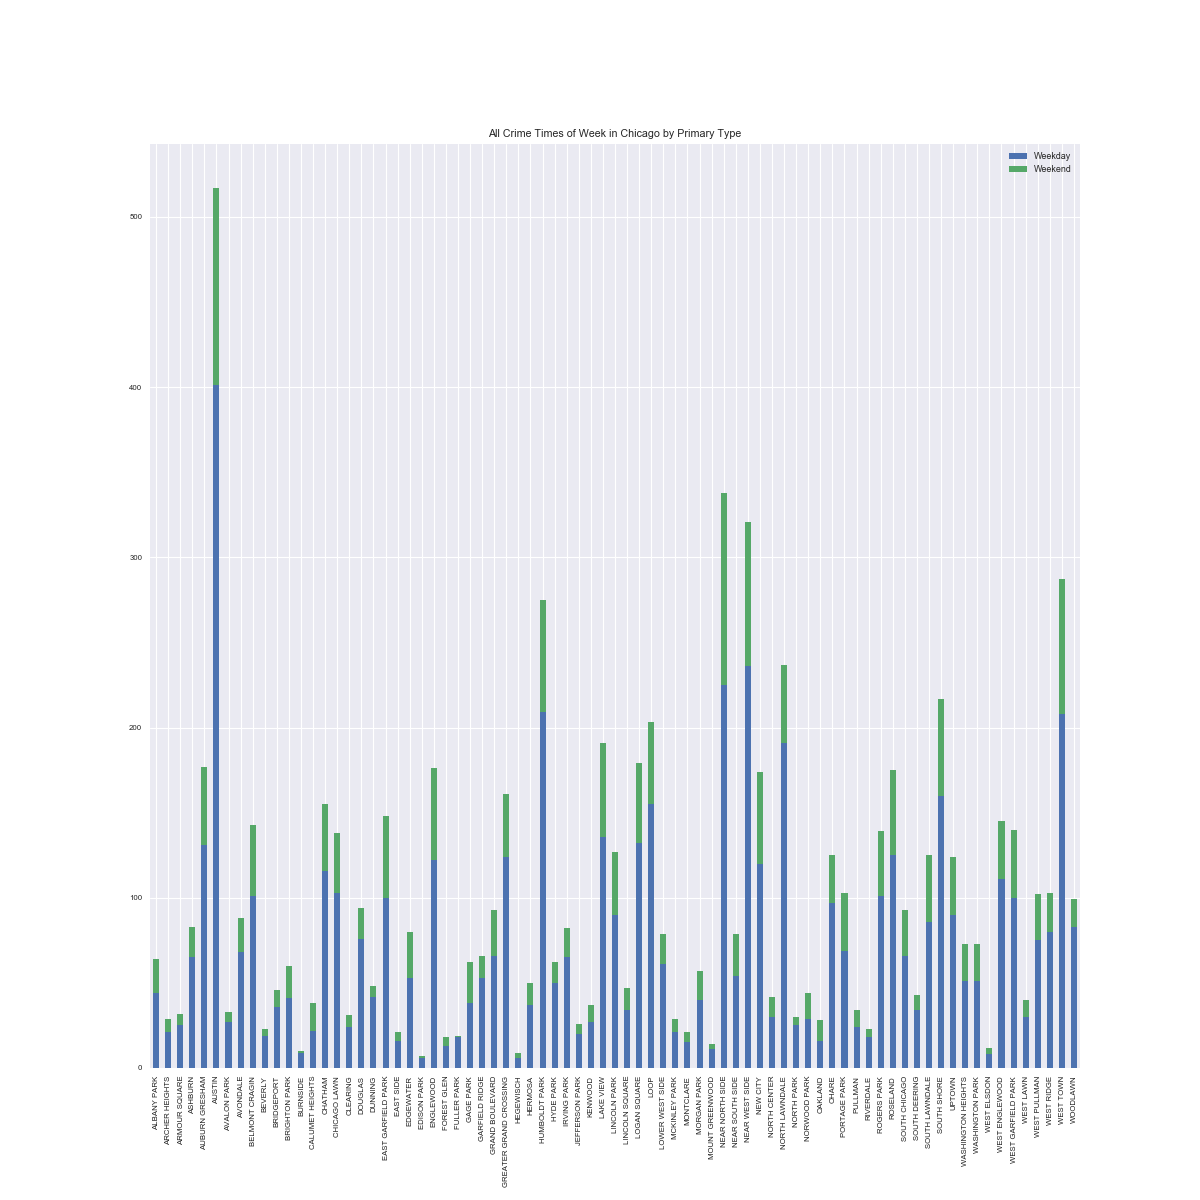

In [34]:
# For seeing all the time of week crimes are committed by primary type
CrimeWeekCounts = pd.DataFrame()
for c in CrimeWeek:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    CrimeWeekCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeWeekCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times of Week in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()